# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_5734/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/Training/pair_features_1_pairs1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,REG,2001-02-09 00:00:00,24.050,23.910,16100.000,8.682,COO,4.839,4.801,883200.000,4.716,3.965,3.308,0.464,3.779,0.299,0.062,3.573,0.312
1,REG,2001-02-12 00:00:00,24.500,24.000,44400.000,8.885,COO,4.869,4.713,1195200.000,4.631,4.254,3.311,0.467,3.795,0.298,0.050,3.561,0.299
2,REG,2001-02-13 00:00:00,24.470,23.900,47600.000,8.733,COO,4.780,4.531,1394400.000,4.441,4.292,3.314,0.470,3.809,0.302,0.050,3.549,0.284
3,REG,2001-02-14 00:00:00,24.350,23.930,51600.000,8.769,COO,4.575,4.363,2244000.000,4.322,4.447,3.318,0.475,3.825,0.309,0.000,3.536,0.259
4,REG,2001-02-15 00:00:00,24.280,23.800,129800.000,8.744,COO,4.512,4.425,1223200.000,4.377,4.366,3.321,0.478,3.841,0.311,0.000,3.523,0.235


In [3]:
total_days = df.Date.nunique()
total_days

5698

In [4]:
df.pnls.describe()

count   5698.000
mean       0.005
std        0.042
min       -0.225
25%        0.000
50%        0.000
75%        0.021
max        0.258
Name: pnls, dtype: float64

### Beta

In [5]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

### Single Ticker Features

In [6]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [7]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,REG,2001-02-09 00:00:00,24.050,23.910,16100.000,8.682,COO,4.839,4.801,883200.000,4.716,3.965,3.308,0.464,3.779,0.299,0.062,3.573,0.312
1,REG,2001-02-12 00:00:00,24.500,24.000,44400.000,8.885,COO,4.869,4.713,1195200.000,4.631,4.254,3.311,0.467,3.795,0.298,0.050,3.561,0.299
2,REG,2001-02-13 00:00:00,24.470,23.900,47600.000,8.733,COO,4.780,4.531,1394400.000,4.441,4.292,3.314,0.470,3.809,0.302,0.050,3.549,0.284
3,REG,2001-02-14 00:00:00,24.350,23.930,51600.000,8.769,COO,4.575,4.363,2244000.000,4.322,4.447,3.318,0.475,3.825,0.309,0.000,3.536,0.259
4,REG,2001-02-15 00:00:00,24.280,23.800,129800.000,8.744,COO,4.512,4.425,1223200.000,4.377,4.366,3.321,0.478,3.841,0.311,0.000,3.523,0.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,REG,2023-09-28 00:00:00,60.290,59.400,1255700.000,59.483,COO,80.077,79.030,1928000.000,79.842,20.359,25.431,8.419,30.220,4.925,0.000,22.199,1.843
5694,REG,2023-09-29 00:00:00,60.820,59.160,1083300.000,58.820,COO,81.135,79.332,1246000.000,79.503,20.682,25.434,8.417,30.011,5.060,0.000,22.305,1.933
5695,REG,2023-10-02 00:00:00,59.560,57.690,736100.000,57.464,COO,79.400,77.425,1311200.000,77.975,20.511,25.438,8.414,29.778,5.170,0.000,22.428,2.048
5696,REG,2023-10-03 00:00:00,57.900,56.290,885500.000,56.396,COO,78.525,77.298,1178800.000,78.228,21.832,25.447,8.409,29.546,5.210,0.000,22.519,2.136


In [8]:
label = 'actual_abs_spread'
features_to_exclude = [] # ['High_P1', 'High_P2', 'Low_P1', 'Low_P2', 'abs_spread', 'abs_spread_mean', 'abs_spread_std']
always_exclude = ['pnls', 'actual_abs_spread_std']
X = df
y = df[label]

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
X = X.drop(always_exclude, axis=1)
X = X.drop(features_to_exclude, axis=1)

In [9]:
X = X.dropna()
X['abs_spread_log_mean_MA'] = np.log(X['abs_spread_mean_MA'])
X['abs_spread_log_std_mean_MA'] = np.log(X['abs_spread_std_MA'])
X = X.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)
X

,High_P1,Low_P1,Close_P1,High_P2,Low_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_log_mean_MA,abs_spread_log_std_mean_MA
0,24.050,23.910,8.682,4.839,4.801,4.716,3.965,3.308,0.464,1.329,-1.207
1,24.500,24.000,8.885,4.869,4.713,4.631,4.254,3.311,0.467,1.334,-1.211
2,24.470,23.900,8.733,4.780,4.531,4.441,4.292,3.314,0.470,1.337,-1.199
3,24.350,23.930,8.769,4.575,4.363,4.322,4.447,3.318,0.475,1.342,-1.175
4,24.280,23.800,8.744,4.512,4.425,4.377,4.366,3.321,0.478,1.346,-1.167
...,...,...,...,...,...,...,...,...,...,...,...
5693,60.290,59.400,59.483,80.077,79.030,79.842,20.359,25.431,8.419,3.409,1.594
5694,60.820,59.160,58.820,81.135,79.332,79.503,20.682,25.434,8.417,3.402,1.621
5695,59.560,57.690,57.464,79.400,77.425,77.975,20.511,25.438,8.414,3.394,1.643
5696,57.900,56.290,56.396,78.525,77.298,78.228,21.832,25.447,8.409,3.386,1.651


In [10]:
y = np.log(y)
y.describe()

count   5698.000
mean       2.404
std        0.839
min       -0.492
25%        1.835
50%        2.445
75%        3.079
max        3.898
Name: actual_abs_spread, dtype: float64

## Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [12]:
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())

2001-02-09 00:00:00 2019-03-26 00:00:00


In [13]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-03-27 00:00:00 2021-06-29 00:00:00


In [14]:
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2021-06-30 00:00:00 2023-10-04 00:00:00


## LSTM Model

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.lstm = LSTM(512, input_shape=self.shape, dropout=0.2, return_sequences = True)
        self.dropout = Dropout(0.2)
        self.dense = Dense(1)

    def call(self, x):
        x = self.lstm(x)
#         x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-22 03:26:28.065347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 03:26:28.813674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [17]:
trainX.shape

(4558, 1, 11)

In [18]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[0], 1, trainX.shape[1]))
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train,
                    validation_data=(valX, y_val), 
                    epochs=50, 
                    batch_size=32,
                    verbose=1, 
                    callbacks=callback,
                    shuffle=False)       

Epoch 1/50


2024-03-22 03:26:29.674463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


143/143 [==============================] - 3s 13ms/step - loss: 1.8206 - mae: 1.8206 - val_loss: 1.9357 - val_mae: 1.9357
Epoch 2/50
143/143 [==============================] - 2s 11ms/step - loss: 0.7631 - mae: 0.7631 - val_loss: 1.1432 - val_mae: 1.1432
Epoch 3/50
143/143 [==============================] - 2s 11ms/step - loss: 0.5741 - mae: 0.5741 - val_loss: 0.8739 - val_mae: 0.8739
Epoch 4/50
143/143 [==============================] - 2s 11ms/step - loss: 0.5163 - mae: 0.5163 - val_loss: 0.6903 - val_mae: 0.6903
Epoch 5/50
143/143 [==============================] - 2s 11ms/step - loss: 0.4732 - mae: 0.4732 - val_loss: 0.5581 - val_mae: 0.5581
Epoch 6/50
143/143 [==============================] - 2s 11ms/step - loss: 0.4517 - mae: 0.4517 - val_loss: 0.4464 - val_mae: 0.4464
Epoch 7/50
143/143 [==============================] - 2s 11ms/step - loss: 0.4286 - mae: 0.4286 - val_loss: 0.4050 - val_mae: 0.4050
Epoch 8/50
143/143 [==============================] - 2s 11ms/step - loss: 0.413

In [19]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  1073152   
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  513       
                                                                 
Total params: 1073665 (4.10 MB)
Trainable params: 1073665 (4.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


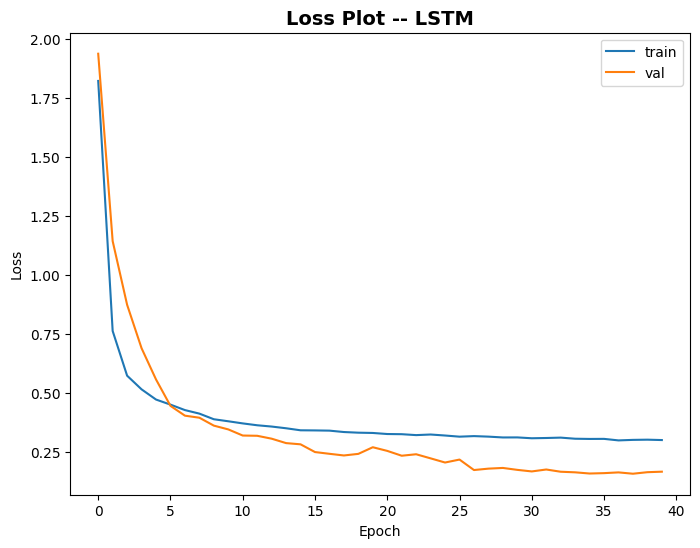

In [20]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


count   570.000
mean      3.316
std       0.316
min       2.653
25%       3.086
50%       3.393
75%       3.570
max       3.848
Name: actual_abs_spread, dtype: float64

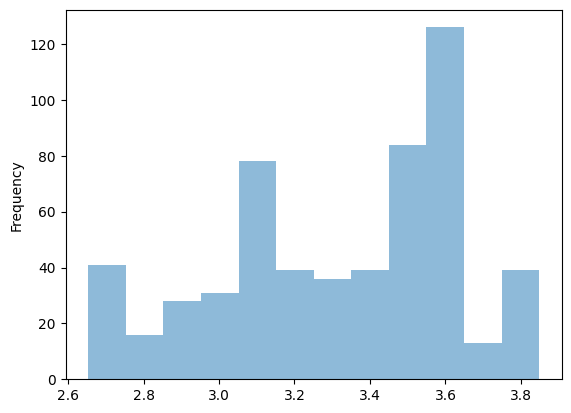

In [22]:
y_test.plot.hist(bins=12, alpha=0.5)
y_test.describe()

count   570.000
mean      3.399
std       0.297
min       2.582
25%       3.184
50%       3.472
75%       3.635
max       3.897
dtype: float64

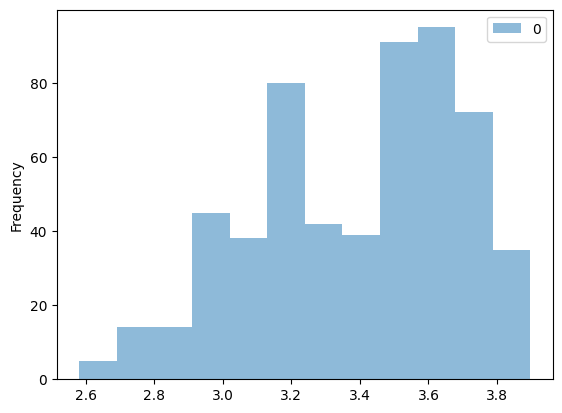

In [23]:
pd.DataFrame(inference_result).plot.hist(bins=12, alpha=0.5)
pd.Series(inference_result).describe()

In [24]:
lstm_mae = (inference_result[:len(y_test)] - y_test).abs().mean()
lstm_mae

0.17395358775509678

In [25]:
inference_result

array([3.7013369, 3.7350328, 3.7548668, 3.7790158, 3.805494 , 3.7934353,
       3.7689567, 3.748561 , 3.7648451, 3.7296147, 3.7333512, 3.7344258,
       3.7555816, 3.7415035, 3.6929896, 3.736303 , 3.7534196, 3.7407196,
       3.7459056, 3.783635 , 3.7871654, 3.8033733, 3.8347297, 3.830449 ,
       3.8116055, 3.7671912, 3.7464392, 3.7335932, 3.7126534, 3.70847  ,
       3.8404944, 3.8538306, 3.8687747, 3.8804321, 3.8599775, 3.8827717,
       3.8926625, 3.8874416, 3.891065 , 3.8821046, 3.8755133, 3.8654892,
       3.8700185, 3.866777 , 3.8621686, 3.8590055, 3.8730233, 3.8526034,
       3.8690128, 3.8562376, 3.8970163, 3.8361745, 3.8336184, 3.8284233,
       3.8118854, 3.8012636, 3.7819333, 3.7712438, 3.7803602, 3.8035   ,
       3.8023238, 3.7665284, 3.7279565, 3.7073684, 3.6958613, 3.669665 ,
       3.6170459, 3.6661332, 3.6568701, 3.6372178, 3.6215398, 3.5791922,
       3.5626938, 3.5518072, 3.544234 , 3.5124652, 3.493151 , 3.5715258,
       3.5938866, 3.6196432, 3.6448972, 3.6315947, 

In [26]:
mae = lstm_mae / y_test.abs().mean()
mae

0.05245196542635863

In [27]:
# Generate the PNL from predicted spread
from pair_trading_foundations.data_generation import ExecutePairTrading

BacktestData = df.loc[X_test.index]

samples = BacktestData
samples = samples.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
samples = samples.drop(always_exclude,axis=1)
samples = samples.drop(features_to_exclude,axis=1)
samples['abs_spread_log_mean_MA'] = np.log(samples.abs_spread_mean_MA)
samples['abs_spread_log_std_mean_MA'] = np.log(samples.abs_spread_std_MA)
samples = samples.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)


model_input = np.reshape(samples, (samples.shape[0], 1, samples.shape[1])).astype(np.float32)
inference_result = lstm_model.predict(model_input).flatten()
BacktestData['pred_abs_spread'] = np.exp(inference_result)
BacktestData['z_score'] = (np.log(BacktestData['pred_abs_spread']) / BacktestData['abs_spread_std_MA'])
BacktestData = BacktestData.reset_index(drop=True)
BacktestData = BacktestData.drop(['actual_abs_spread', 'actual_abs_spread_std'], axis=1)
BacktestData 

18/18 [==============================] - 0s 2ms/step


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,pred_abs_spread,z_score
0,REG,2021-06-30 00:00:00,64.800,63.860,955600.000,57.924,COO,99.415,98.415,931600.000,99.027,41.103,43.372,6.393,40.922,4.224,0.020,40.501,0.876
1,REG,2021-07-01 00:00:00,65.390,63.020,718400.000,58.602,COO,101.200,99.180,1054800.000,100.709,42.107,43.372,6.393,40.900,4.214,0.030,41.889,0.886
2,REG,2021-07-02 00:00:00,65.290,64.180,559300.000,58.321,COO,102.027,100.762,838000.000,101.896,43.574,43.373,6.393,40.906,4.218,0.036,42.729,0.890
3,REG,2021-07-06 00:00:00,64.450,62.950,982700.000,57.743,COO,102.485,100.893,676000.000,102.346,44.603,43.383,6.393,40.913,4.224,0.042,43.773,0.895
4,REG,2021-07-07 00:00:00,63.800,62.690,755000.000,57.191,COO,103.750,102.058,999200.000,103.413,46.221,43.410,6.388,40.939,4.252,0.042,44.947,0.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,REG,2023-09-28 00:00:00,60.290,59.400,1255700.000,59.483,COO,80.077,79.030,1928000.000,79.842,20.359,25.431,8.419,30.220,4.925,0.000,23.205,0.638
566,REG,2023-09-29 00:00:00,60.820,59.160,1083300.000,58.820,COO,81.135,79.332,1246000.000,79.503,20.682,25.434,8.417,30.011,5.060,0.000,23.641,0.625
567,REG,2023-10-02 00:00:00,59.560,57.690,736100.000,57.464,COO,79.400,77.425,1311200.000,77.975,20.511,25.438,8.414,29.778,5.170,0.000,23.581,0.611
568,REG,2023-10-03 00:00:00,57.900,56.290,885500.000,56.396,COO,78.525,77.298,1178800.000,78.228,21.832,25.447,8.409,29.546,5.210,0.000,24.795,0.616


In [35]:
pnls = []
entry_signal = 2    # Make sure this matches with data pipeline
exit_signal = 0.5   # Make sure this matches with data pipeline
test_len = 20       # Make sure this matches with data pipeline
for idx in range(BacktestData.shape[0]):
    if (idx > BacktestData.shape[0]-test_len-1):
        pnls.append(np.nan)
    else:
        current_row = BacktestData.loc[idx]
        result = ExecutePairTrading(current_row.pred_abs_spread,   # Use predicted spread
                                    current_row.abs_spread_std_MA, # Use current std deviation
                                    entry_signal=entry_signal,
                                    exit_signal=exit_signal
                                ).execute(
                                    # Forward window
                                    vec1=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P1'].values,
                                    vec2=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P2'].values,
                                    dates=BacktestData.loc[(idx+1):(idx+test_len)]['Date'].values,
                                    base_fund=100,
                                )

        pnls.append(result.final_pl_pct)

BacktestData['pred_pnls'] = pnls
BacktestData = BacktestData.dropna()

strategy = BacktestData.loc[(abs(BacktestData['z_score']) > 0.95) & (BacktestData['pred_pnls'] > 0)]
strategy

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,pred_abs_spread,z_score,pred_pnls
14,REG,2021-07-21 00:00:00,66.450,64.770,1027900.000,59.605,COO,100.940,99.270,880000.000,100.334,40.729,43.536,6.315,40.394,3.741,0.042,40.165,0.987,0.036
19,REG,2021-07-28 00:00:00,65.690,64.150,401900.000,58.412,COO,103.942,102.775,708400.000,103.375,44.963,43.571,6.305,40.234,3.563,0.033,43.976,1.062,0.010
20,REG,2021-07-29 00:00:00,66.300,64.760,551900.000,59.036,COO,104.713,103.740,984800.000,104.190,45.154,43.594,6.298,40.220,3.541,0.033,44.131,1.069,0.009
21,REG,2021-07-30 00:00:00,66.380,65.090,1125700.000,59.135,COO,106.132,104.290,713200.000,105.407,46.272,43.630,6.282,40.256,3.592,-0.033,44.852,1.059,0.023
25,REG,2021-08-05 00:00:00,65.360,63.230,1171100.000,59.054,COO,103.948,102.027,821600.000,102.890,43.837,43.750,6.247,40.557,3.892,0.042,43.258,0.968,0.023
26,REG,2021-08-06 00:00:00,68.320,66.240,985000.000,60.030,COO,103.565,102.412,889200.000,103.215,43.185,43.753,6.246,40.609,3.906,0.042,42.370,0.959,0.010
27,REG,2021-08-09 00:00:00,66.350,65.160,606200.000,59.117,COO,103.567,101.565,1034000.000,101.786,42.669,43.764,6.242,40.646,3.915,0.042,41.829,0.954,0.011
140,REG,2022-01-19 00:00:00,75.490,72.760,650700.000,67.090,COO,100.755,99.285,2390000.000,99.504,32.414,42.779,6.089,34.745,3.062,0.049,31.207,1.124,0.003
142,REG,2022-01-21 00:00:00,71.000,69.770,1042100.000,64.394,COO,98.912,96.978,965600.000,97.050,32.656,42.696,6.136,34.539,2.959,0.041,32.118,1.172,0.014
154,REG,2022-02-08 00:00:00,71.370,69.850,1024600.000,64.835,COO,101.473,97.310,1660800.000,101.241,36.406,42.317,6.442,33.288,1.955,0.034,35.211,1.822,0.038


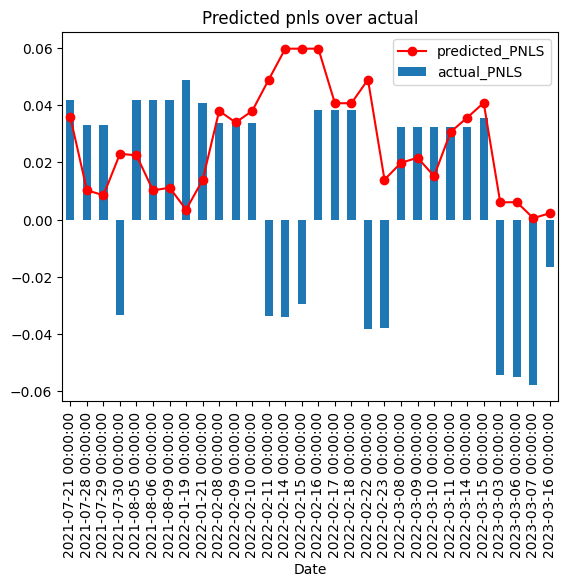

<Figure size 800x600 with 0 Axes>

In [75]:
pnl_filters = strategy.filter(items=['Date', 'pnls', 'pred_pnls'])
pnl_filters = pnl_filters.rename(columns={'pnls': 'actual_PNLS', 'pred_pnls': 'predicted_PNLS'})
ax = pnl_filters.plot(x='Date',y=['predicted_PNLS'],  linestyle='-', marker='o', color='red')
pnl_filters.plot(x='Date',y=['actual_PNLS'], kind='bar', ax=ax)
ax.set_title('Predicted pnls over actual')
plt.figure(figsize=(8,6))
plt.show()

In [82]:
# Strategy 1: Execute each recommended trade by X amount
average_pnl = pnl_filters.actual_PNLS.sum() / len(pnl_filters.actual_PNLS)
print('Returns: ', average_pnl)

Returns:  0.011561189593337788


In [99]:
# Strategy 2: Execute top 10 recommended trade by X amount
best_num = 10
pnl_filters = pnl_filters.reset_index(drop=True)
# Get the top 10 predictions for PNL
sorted_indices = pnl_filters.predicted_PNLS.argsort()[::-1]
top_k = sorted_indices[sorted_indices < best_num]

# Retrieve the actual PNL
average_pnl = pnl_filters.actual_PNLS[top_k].sum() / best_num
print('Returns: ', average_pnl)

Returns:  0.0324931364575972


In [100]:
# Normality test

from scipy.stats import shapiro
# normality test
stat, p = shapiro(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.961, p=0.000
Sample does not look Gaussian (reject H0)


In [101]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=47.396, p=0.000
Sample does not look Gaussian (reject H0)


In [102]:
# Anderson-Darling Test
from scipy.stats import anderson
result = anderson(inference_result)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
if result.statistic < result.critical_values[i]:
    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
else:
    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 7.413
1.000: 1.084, data does not look normal (reject H0)
